# wglimpse on MICE DES-like data

In [1]:
%matplotlib inline

import numpy as np
from astropy.io import fits
from scipy import ndimage
import math
import matplotlib.pyplot as plt


In [2]:
plt.rcParams['figure.figsize'] = (16, 6); plt.rcParams.update({'font.size': 13});

ncov (256, 256)
ps1d (182,)


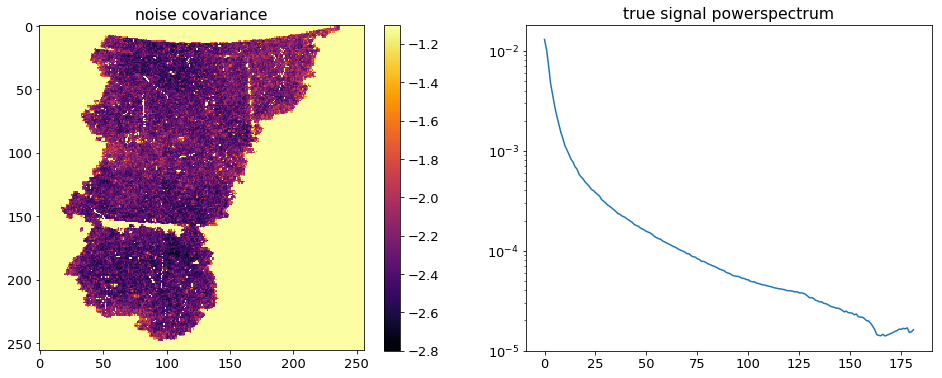

In [3]:
# check the noise covariance and power spectrum

Ncov = np.load('../data/mice/Ncov.npy') 
print('ncov', Ncov.shape)

npix = Ncov.shape[0]

# # rotate Ncov image
# Ncov_updwn = np.zeros((npix*npix))
# Ncov_vec = np.reshape(Ncov, -1)
# for y in range(npix):
#     for x in range(npix):
#         pos = (npix - y - 1) * npix + (npix - x - 1)
#         Ncov_updwn[y * npix + x] = Ncov_vec[pos]

# Ncov_updwn = np.reshape(Ncov_updwn,(npix,npix))


ps1d = np.load('../data/mice/cosmosis_mice_power_spectrum1d.npy') 
# ps1d = np.load('../data/mice/projected_mice_power_noisy2.npy') #* npix**2
print('ps1d', ps1d.shape)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(np.log10(Ncov), interpolation='none', cmap='inferno',vmin=-2.8,vmax=-1.1) 
ax1.set_title('noise covariance'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.plot(ps1d) 
ax2.set_title('true signal powerspectrum'), ax2.set_yscale('log')

plt.show()
#vmin = 0, vmax = np.max(Ncov.flatten()[np.where(Ncov.flatten() <1)])

In [22]:
np.max(Ncov)

1e+18

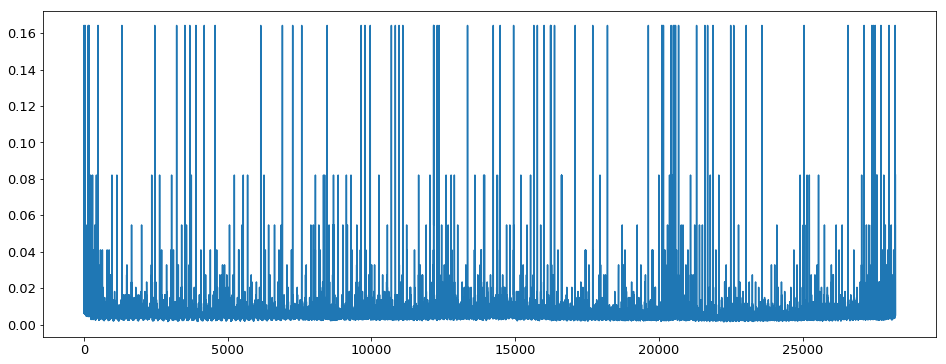

0.164204530775
0.00681910922647


In [4]:


plt.plot(Ncov.flatten()[np.where(Ncov.flatten() <1)])
plt.show()

print(np.max(Ncov.flatten()[np.where(Ncov.flatten() <1)]))
print(np.mean(Ncov.flatten()[np.where(Ncov.flatten() <1)]))

ps1d (182,)


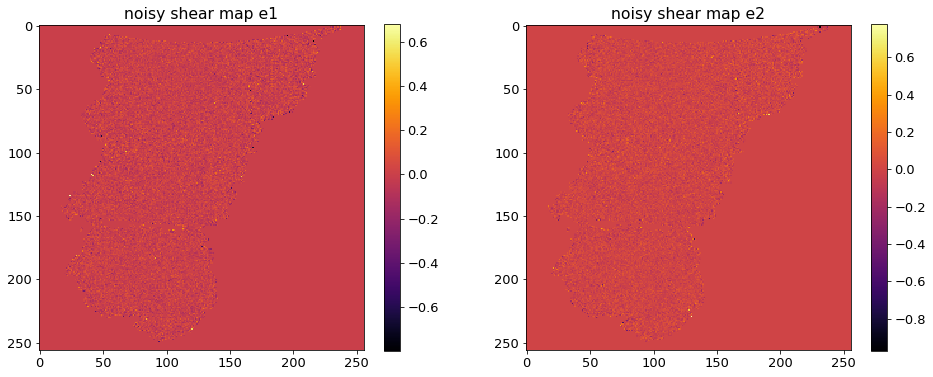

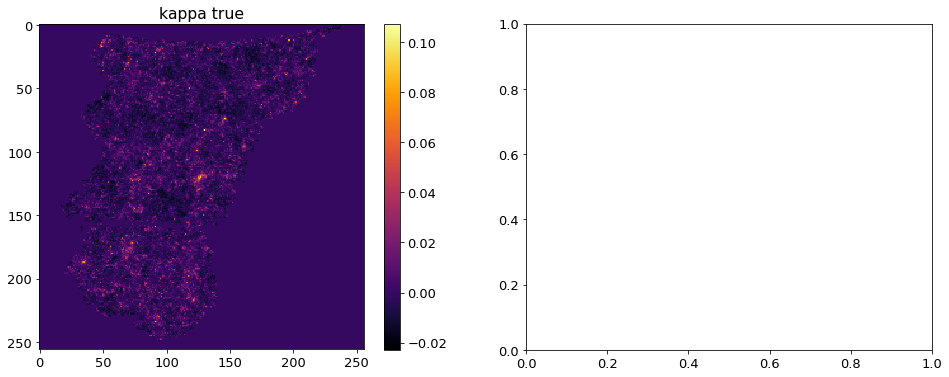

In [5]:
# load the shear maps as well

e1 = np.load('../data/mice/sv_patches/e1_noisy_030419_0.npy')
e2 = np.load('../data/mice/sv_patches/e2_noisy_030419_0.npy')
ktrue = np.load('../data/mice/sv_patches/kappa_true_030419_0.npy')

print('ps1d',ps1d.shape)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(e1, interpolation='none', cmap='inferno') 
ax1.set_title('noisy shear map e1'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(e2, interpolation='none', cmap='inferno') 
ax2.set_title('noisy shear map e2'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(ktrue, interpolation='none', cmap='inferno') 
ax1.set_title('kappa true'), plt.colorbar(cax1, ax=ax1)

plt.show()


In [6]:
# wiener filtering inversion

# define the kappa to shear operator
def H_operator(ka_map, kb_map):
    
    # ka_map and kb_map should be of the same size
    [nx,ny] = ka_map.shape
    
    ka_map_fft = np.fft.fft2(ka_map)
    kb_map_fft = np.fft.fft2(kb_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1 # avoid division with zero
    kafc =  (p1 * ka_map_fft - p2 * kb_map_fft) / f2
    kbfc =  (p1 * kb_map_fft + p2 * ka_map_fft) / f2
    
    g1_map = np.fft.ifft2(kafc).real
    g2_map = np.fft.ifft2(kbfc).real
    
    return g1_map, g2_map


# define the shear to convergence operator
def H_adjoint(g1_map, g2_map):
    
    [nx,ny] = g1_map.shape
    
    g1_map_ifft = np.fft.ifft2(g1_map)
    g2_map_ifft = np.fft.ifft2(g2_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1
    g1fc =  (p1 * g1_map_ifft + p2 * g2_map_ifft) / f2
    g2fc =  (p1 * g2_map_ifft - p2 * g1_map_ifft) / f2
    
    kappa1 = np.fft.fft2(g1fc).real
    kappa2 = np.fft.fft2(g2fc).real
    
    return kappa1, kappa2

def compute_spectrum_map(Px,size):
    power_map = np.zeros((size, size), dtype = float)
    k_map =  np.zeros((size, size), dtype = float)

    for (i,j), val in np.ndenumerate(power_map):

        k1 = i - size/2.0
        k2 = j - size/2.0
        k_map[i, j] = (np.sqrt(k1*k1 + k2*k2))

        if k_map[i,j]==0:
            #print(i,j)
            power_map[i, j] = 1e-15
        else:
            #print(k_map[i, j])
            power_map[i, j] = Px[int(k_map[i, j])]
    return power_map


def prox_wiener_filtering(gamma1, gamma2, Px_map, Ncv):
        
    # initiallize
    nx = gamma1.shape[0]
    xg = np.zeros((nx,nx)) + 1j * np.zeros((nx,nx))
    
    # find the minimum noise variance
    tau = np.min(Ncv)
    
    # set the step size
    eta = 1.83 * tau
    
    # compute signal coefficient
    Esn = eta / Ncv
    
    # calculate the wiener filter coefficients
    Wfc = Px_map / (Px_map + eta)
    
    n_iter = 100
    for n in range(n_iter):
        t1,t2 = H_operator(xg.real, xg.imag)                              # H * xg
        t1,t2 = H_adjoint(Esn*(gamma1 - t1), Esn*(gamma2 - t2))           # H^T(eta / Sn * (y- H * xg))
        t = xg + (t1 + 1j*t2)                                             # xg + H^T(eta / Sn * (y- H * xg))
        
        xg = np.fft.ifft2(np.fft.fftshift(Wfc * np.fft.fftshift(np.fft.fft2(t)))) # wiener filtering in fourier space
        
    return xg.real, xg.imag

(kpwa,kpwb) = prox_wiener_filtering(-e1, -e2, compute_spectrum_map(ps1d,npix), Ncov)
    


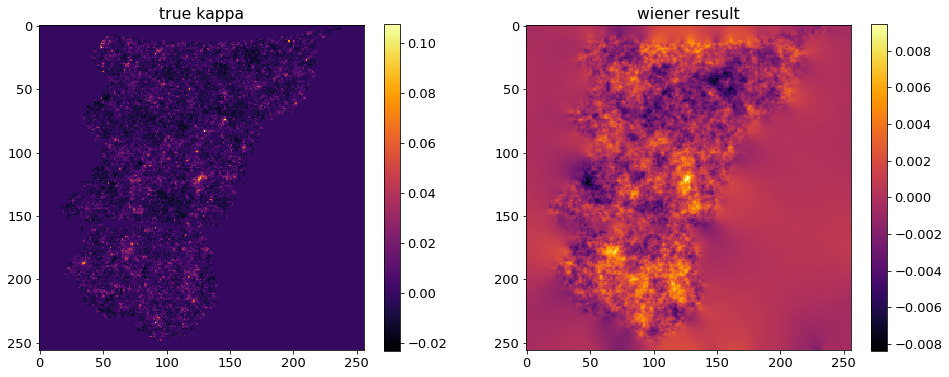

In [8]:

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(ktrue, interpolation='none', cmap='inferno') # , vmin= -.03, vmax = .03
ax1.set_title('true kappa'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kpwa, interpolation='none', cmap='inferno') 
ax2.set_title('wiener result'), plt.colorbar(cax2, ax=ax2)

plt.show()


In [9]:
# # e1 -= np.mean(e1)
# # e2 -= np.mean(e2)
# plt.loglog(ps1d)
# plt.show()

# plt.imshow(compute_spectrum_map(ps1d,npix))

# plt.show()

In [10]:

# # function to generate a convergence field out of a gaussian spectrum
# def generate_gaussian_field(pm2d, size):
            
#     power_sample = np.random.normal(loc=0.0, scale=np.sqrt(0.5 * np.reshape(pm2d, -1))) +\
#                1j *  np.random.normal(loc=0.0, scale=np.sqrt(0.5 *  np.reshape(pm2d, -1)))
#     power_sample = np.reshape(power_sample, (size, size))
#     map_fourier = np.zeros((size,size), dtype = complex)
    
#     for (i, j,), value in np.ndenumerate(map_fourier):
#         n = i - int(size/2)
#         m = j - int(size/2)

#         if n == 0 and m ==0:
#             map_fourier[i,j] = 1e-15

#         elif i ==0 or j == 0:
#             map_fourier[i,j] = np.sqrt(2.0)*power_sample[i,j].real

#         else:
#             map_fourier[i,j] = power_sample[i,j] #
#             map_fourier[size - i,size - j] = np.conj(power_sample[i,j])

#     map_pixel = np.fft.ifft2(np.fft.fftshift(map_fourier))
    
#     return map_pixel

# power_map2d = compute_spectrum_map(ps1d,npix)
# print('power_map_size',power_map2d.shape)

# rfield = generate_gaussian_field(power_map2d, npix)
# print('rfield_size',rfield.shape)

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(ktrue, interpolation='none', cmap='inferno', vmin=-.02, vmax=.02, origin='lower') 
# ax1.set_title('true kappa'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(np.real(rfield), interpolation='none', cmap='inferno', origin='lower') 
# ax2.set_title('random field'), plt.colorbar(cax2, ax=ax2)

# plt.show()



In [26]:
# save data as fits files


# # save spectrum
# hdu_kappa = fits.PrimaryHDU(ps1d)
# hdul_kappa = fits.HDUList([hdu_kappa])
# hdul_kappa.writeto('../data/mice/fits_files/mice_ps1d_kappa.fits')

# # save gamma a
# hdu_kappa = fits.PrimaryHDU(-e1)
# hdul_kappa = fits.HDUList([hdu_kappa])
# hdul_kappa.writeto('../data/mice/fits_files/mice_g1_map0.fits')

# # save gamma b
# hdu_kappa = fits.PrimaryHDU(-e2)
# hdul_kappa = fits.HDUList([hdu_kappa])
# hdul_kappa.writeto('../data/mice/fits_files/mice_g2_map0.fits')

# # save noise covariance
# hdu_kappa = fits.PrimaryHDU(np.reshape(Ncov,-1))
# hdul_kappa = fits.HDUList([hdu_kappa])
# hdul_kappa.writeto('../data/mice/fits_files/mice_noisecov_map.fits')




### check wiener map


In [12]:
# check wiener c++ and wiener python
try: 
    kwiener = fits.getdata('../build/kwiener.fits')

    fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    cax1 = ax1.imshow(kpwa, interpolation='none', cmap='inferno', origin='lower') # , vmin= -.02, vmax = .04 
    ax1.set_title('kappa wiener python'), plt.colorbar(cax1, ax=ax1)
    cax2 = ax2.imshow(kwiener, interpolation='none', cmap='inferno', origin='lower') # , vmin= vn, vmax = vx # , gist_stern
    ax2.set_title('kappa wiener c++'), plt.colorbar(cax2, ax=ax2)

    fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    cax1 = ax1.imshow(kwiener - kpwa, interpolation='none', cmap='inferno', origin='lower') # , vmin= -.02, vmax = .04 
    ax1.set_title('their difference'), plt.colorbar(cax1, ax=ax1)

    plt.show()
except:
    print('Wiener filtering c++ map missing')

Wiener filtering c++ map missing


In [13]:

# # check the glimpse plus wiener result

# kwiener = fits.getdata('../build/kwiener.fits')
# kgl = fits.getdata('../build/kappa_mice_wglimpse.fits') 
# kfinal = kgl+kwiener

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(ktrue, interpolation='none', cmap='inferno', origin='lower') # , vmin= -.02, vmax = .04 
# ax1.set_title('kappa from survey'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kwiener, interpolation='none', cmap='inferno', origin='lower') # , vmin= vn, vmax = vx # , gist_stern
# ax2.set_title('kappa wiener'), plt.colorbar(cax2, ax=ax2)

# fig2, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kgl, interpolation='none', cmap='inferno', origin='lower') 
# ax1.set_title('glimpse solution'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kwiener + kgl, interpolation='none', cmap='inferno', origin='lower') # , vmin= vn, vmax = vx gist_stern
# ax2.set_title('glimpse plus wiener'), plt.colorbar(cax2, ax=ax2)

# plt.show()

# # print(kgl[:4,:4])



### check Kaiser Squires 

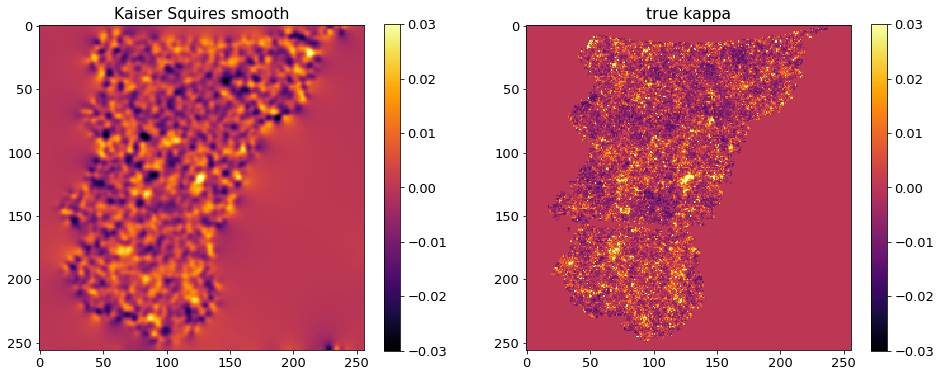

In [17]:

# Compute once the Fourier kernels for the transform
npix = e1.shape[0]
k1, k2 = np.meshgrid(np.fft.fftfreq(npix), np.fft.fftfreq(npix))
denom = k1*k1 + k2*k2
denom[0, 0] = 1  # avoid division by 0
kernel1 = (k1**2 - k2**2)/denom
kernel2 = (2*k1*k2)/denom

def kappa_to_gamma(kappa):
    k = np.fft.fft2(kappa)
    g1 = np.fft.ifft2(kernel1 * k) 
    g2 = np.fft.ifft2(kernel2 * k)
    return g1.real - g2.imag, g2.real + g1.imag 

def gamma_to_kappa(gam1, gam2):
    g = gam1 + 1j*gam2
    return np.fft.ifft2((kernel1 - 1j*kernel2)* np.fft.fft2(g))


# compute the Kaiser-Squares map
kgka = gamma_to_kappa(-e1, -e2)

# smooth out the KS maps 
kgkas = ndimage.filters.gaussian_filter(kgka.real, sigma = 2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kgkas, interpolation='none', cmap='inferno', vmin=-.03, vmax=.03) 
ax1.set_title('Kaiser Squires smooth'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(ktrue, interpolation='none', cmap='inferno', vmin=-.03, vmax=.03) 
ax2.set_title('true kappa'), plt.colorbar(cax2, ax=ax2)
plt.show()


# plt.imshow(kgkas, interpolation='none', cmap='inferno') # , origin='lower' 
# plt.title('Kaiser Squires')
# plt.colorbar()
# plt.show()


### check glimpse

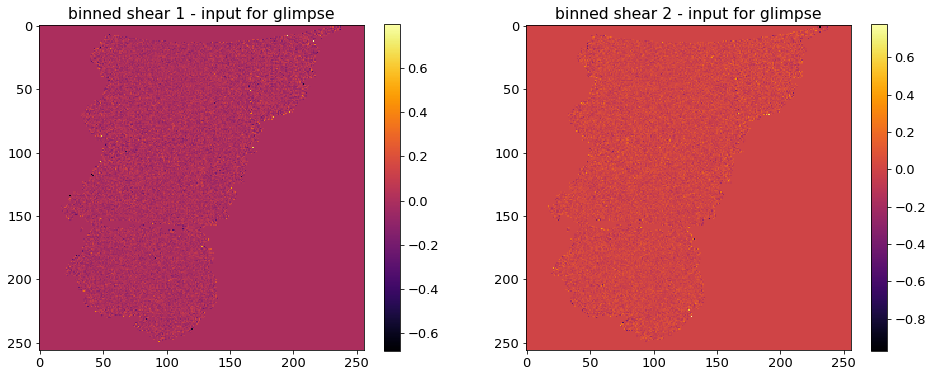

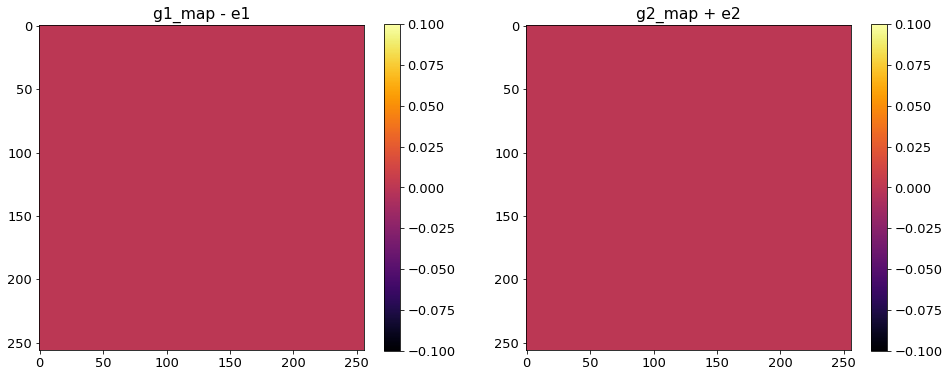

In [28]:
# check shear input for wglimpse in c++
g1_map = fits.getdata('../build/g1_map.fits')
g2_map = fits.getdata('../build/g2_map.fits')

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(g1_map, interpolation='none', cmap='inferno') 
ax1.set_title('binned shear 1 - input for glimpse'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(g2_map, interpolation='none', cmap='inferno') 
ax2.set_title('binned shear 2 - input for glimpse'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(g1_map + e1, interpolation='none', cmap='inferno') 
ax1.set_title('g1_map - e1'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(g2_map - e2, interpolation='none', cmap='inferno') 
ax2.set_title('g2_map + e2'), plt.colorbar(cax2, ax=ax2)


plt.show()

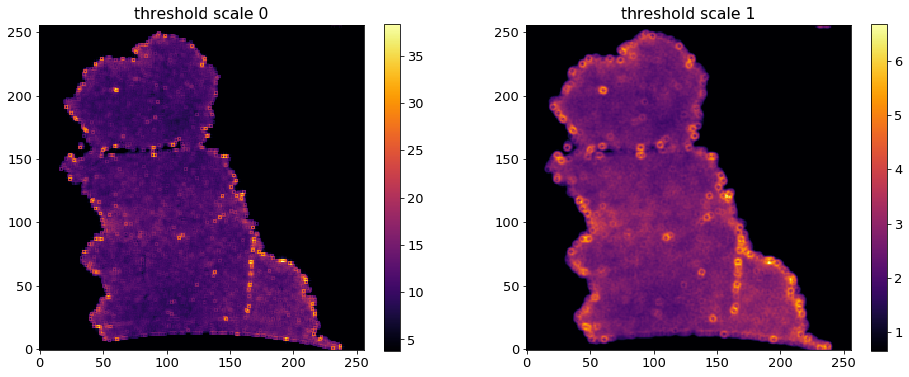

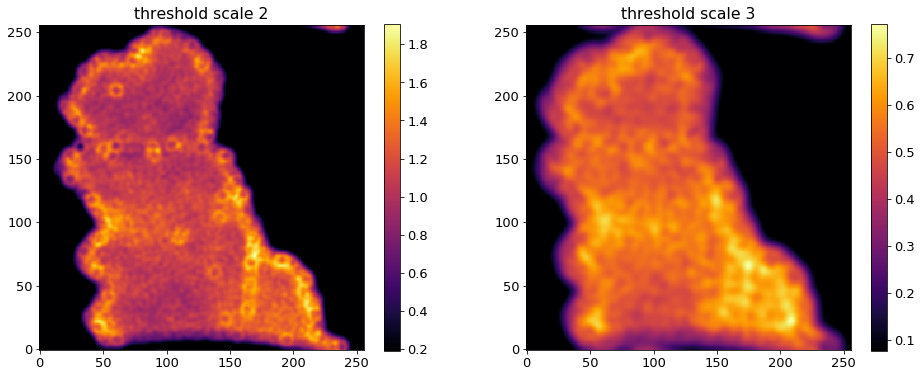

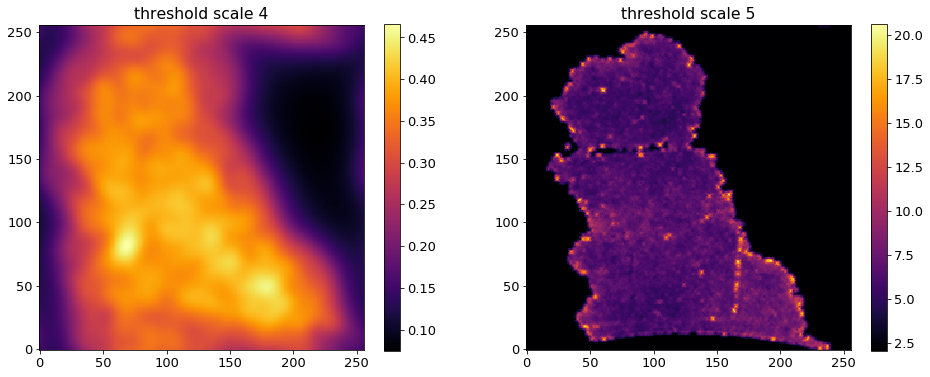

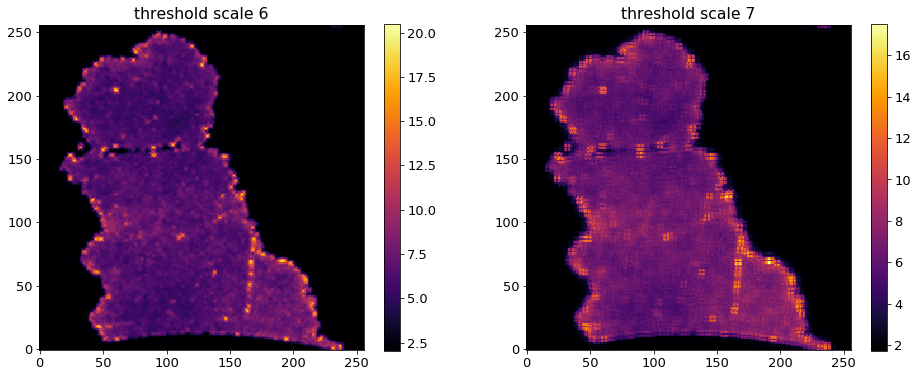

In [29]:
thr = fits.getdata('../build/thresholds.fits')

for i in range(0,np.int(thr.shape[0]),2):
    fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
    cax1 = ax1.imshow(thr[i,:,:], interpolation='none', cmap='inferno', origin='lower') 
    ax1.set_title('threshold scale ' + str(i)), plt.colorbar(cax1, ax=ax1)
    cax2 = ax2.imshow(thr[i+1,:,:], interpolation='none', cmap='inferno', origin='lower') 
    ax2.set_title('threshold scale ' + str(i+1)), plt.colorbar(cax2, ax=ax2)

# thr2 = fits.getdata('../build/thresholds2.fits')

# for i in range(0,np.int(thr2.shape[0]),2):
#     fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
#     cax1 = ax1.imshow(thr[i,:,:]-thr2[i,:,:], interpolation='none', cmap='inferno', origin='lower') 
#     ax1.set_title('threshold2 scale ' + str(i)), plt.colorbar(cax1, ax=ax1)
#     cax2 = ax2.imshow(thr[i+1,:,:]-thr2[i+1,:,:], interpolation='none', cmap='inferno', origin='lower') 
#     ax2.set_title('threshold2 scale ' + str(i+1)), plt.colorbar(cax2, ax=ax2)


plt.show()

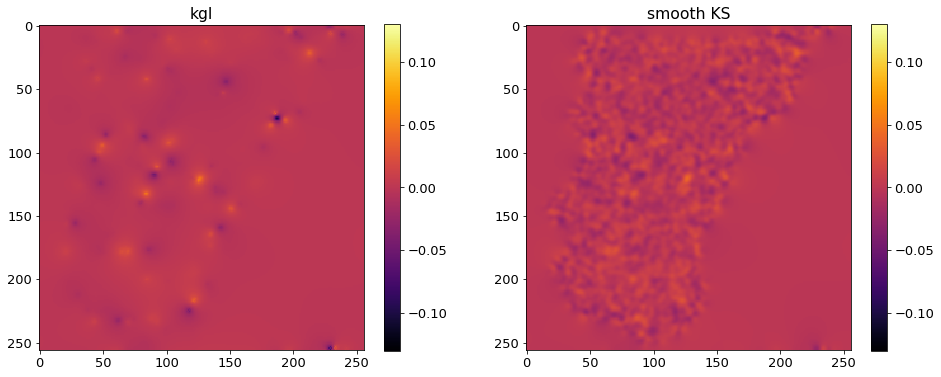

In [30]:
# check the glimpse output

kgl = fits.getdata('../build/kappa_mice_wglimpse.fits') 

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kgl, interpolation='none', cmap='inferno', vmin= -.03, vmax = .03) 
ax1.set_title('kgl'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kgkas, interpolation='none', cmap='inferno', vmin= -.03, vmax = .03) # 
ax2.set_title('smooth KS'), plt.colorbar(cax2, ax=ax2)
plt.show()

# plt.figure(figsize=(11, 9))
# plt.imshow(kgl, interpolation='none', cmap='inferno',vmin=-.03,vmax=.03 ) #,vmin=-.04,vmax=.04 gist_stern inferno ,vmin=-.03,vmax=.03 
# plt.colorbar()
# plt.show()

# ktrue_rot = np.zeros((npix*npix))
# ktruej = np.reshape(ktrue, -1)
# for y in range(npix):
#     for x in range(npix):
#         pos = (npix - y - 1) * npix + (npix - x - 1)
#         ktrue_rot[y * npix + x] = ktruej[pos]

# ktrue_rot = np.reshape(ktrue_rot,(npix,npix))

# plt.figure(figsize=(11, 9))
# plt.imshow(ktrue, interpolation='none', cmap='inferno',vmin=-.03,vmax=.03 ) #,vmin=-.04,vmax=.04 gist_stern inferno 
# plt.colorbar()
# plt.show()

# print(kgl[:4,:4])

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(ktrue, interpolation='none', cmap='inferno', vmin= -.1, vmax = .1) 
# ax1.set_title('kappa true'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kgl, interpolation='none', cmap='inferno', vmin= -.1, vmax = .1) # 
# ax2.set_title('kappa '), plt.colorbar(cax2, ax=ax2)
# plt.show()




In [24]:
# plt.figure(figsize=(11, 9))
# plt.imshow(ktrue_rot+kgl*0.5 , interpolation='none', cmap='inferno',vmin=-.03,vmax=.03 ) #,vmin=-.04,vmax=.04 gist_stern inferno
# plt.colorbar()
# plt.show()

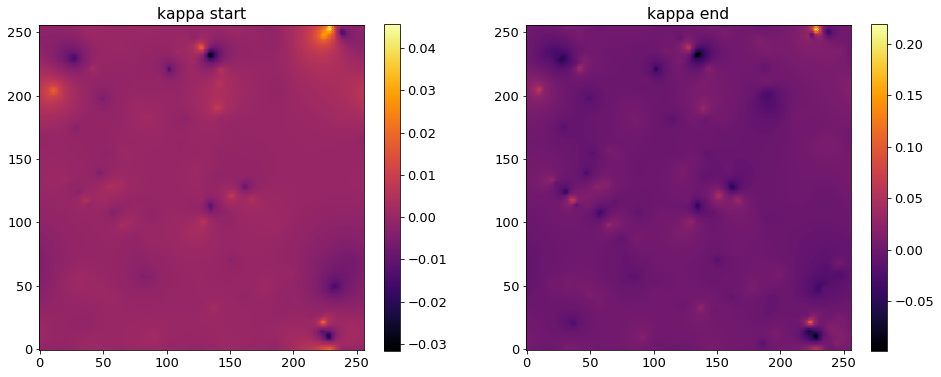

In [24]:
kpp0 = fits.getdata('../build/kappa_000.fits') 
kpp1 = fits.getdata('../build/kappa_499.fits') 

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kpp0, interpolation='none', cmap='inferno', origin='lower') 
ax1.set_title('kappa start'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kpp1, interpolation='none', cmap='inferno', origin='lower') 
ax2.set_title('kappa end'), plt.colorbar(cax2, ax=ax2)

plt.show()

In [26]:
# # plot back projection 

# bpj = fits.getdata('../build/back_proj.fits')

# plt.figure(figsize=(18, 16))
# plt.imshow(bpj.T, interpolation='none', cmap='inferno') 
# plt.title('back projection'), plt.colorbar()


# plt.show()

### check wiener plus glimpse

In [27]:
# load results from c++
kwr = fits.getdata('../build/kwiener.fits') 
kgl = fits.getdata('../build/kappa_mice_wglimpse.fits') 


kwrt = np.zeros((npix*npix))
kwvj = np.reshape(kwr, -1)
for y in range(npix):
    for x in range(npix):
        pos = (npix - y - 1) * npix + (npix - x - 1)
        kwrt[y * npix + x] = kwvj[pos]

kwrt = np.reshape(kwrt,(npix,npix))

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kwrt, interpolation='none', cmap='inferno') 
ax1.set_title('kappa wiener'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kgl, interpolation='none', cmap='inferno') # , origin='lower' 
ax2.set_title('kappa glimpse'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(ktrue_rot, interpolation='none', cmap='inferno') 
ax1.set_title('kappa true'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kwrt + kgl, interpolation='none', cmap='inferno') 
ax2.set_title('kappa wiener plus glimpse'), plt.colorbar(cax2, ax=ax2)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../build/kwiener.fits'

In [28]:
# # compute the KS estimate
# kw = gamma_to_kappa(g1_map, g2_map)
# # print(kw[:2,:2])
# # fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# # cax1 = ax1.imshow(kw.real, interpolation='none', cmap='inferno') 
# # ax1.set_title('KS e mode'), plt.colorbar(cax1, ax=ax1)
# # cax2 = ax2.imshow(kw.imag, interpolation='none', cmap='inferno') 
# # ax2.set_title('KS b mode'), plt.colorbar(cax2, ax=ax2)

# # check the c++ gamma_to_kappa
# kks = fits.getdata('../build/gamma_to_kappa.fits') 

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kw.real , interpolation='none', cmap='inferno') 
# ax1.set_title('KS python'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kks, interpolation='none', cmap='inferno') 
# ax2.set_title('KS c++'), plt.colorbar(cax2, ax=ax2)

# diff = kw.real - kks 
# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(diff, interpolation='none', cmap='inferno') 
# ax1.set_title('diff'), plt.colorbar(cax1, ax=ax1)

# plt.show()

(array([  4.00000000e+00,   5.00000000e+00,   4.90000000e+01,
          1.01200000e+03,   1.15040000e+04,   4.99350000e+04,
          2.83900000e+03,   1.59000000e+02,   2.50000000e+01,
          4.00000000e+00]),
 array([-0.66740813, -0.53874773, -0.41008732, -0.28142692, -0.15276651,
        -0.02410611,  0.1045543 ,  0.2332147 ,  0.3618751 ,  0.49053551,
         0.61919591]),
 <a list of 10 Patch objects>)

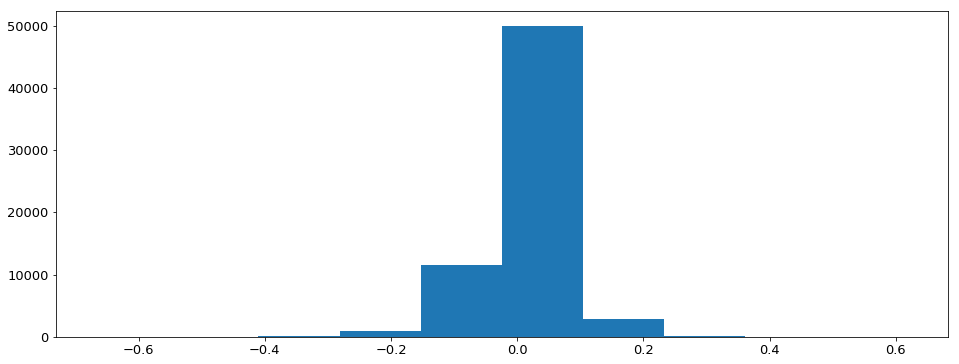

In [39]:
plt.hist(np.reshape(kw.real - kks,-1))

In [40]:
# bpj = fits.getdata('../build/back_proj.fits')

# bpn = np.zeros(npix*npix)
# bpj = np.reshape(bpj,-1)
# for y in range(npix):
#     for x in range(npix):
#         pos = (npix - y - 1) * npix + (npix - x - 1)
#         bpn[x * npix + y] = bpj[pos]
        
# bpn = np.reshape(bpn,(npix,npix))

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kw.real, interpolation='none', cmap='inferno') 
# ax1.set_title('KS python'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(bpn , interpolation='none', cmap='inferno') 
# ax2.set_title('back projection '), plt.colorbar(cax2, ax=ax2)

# plt.show()


### check shear to gamma operators

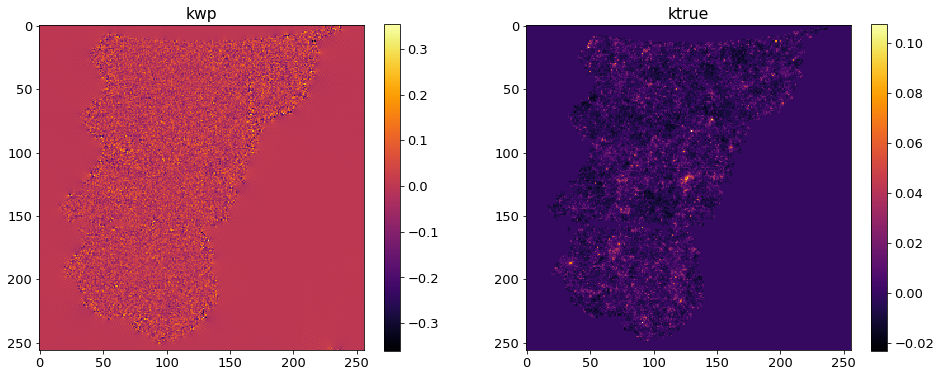

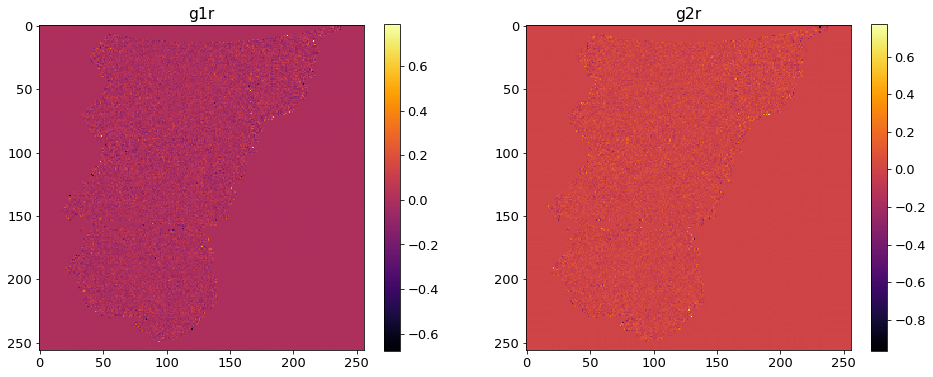

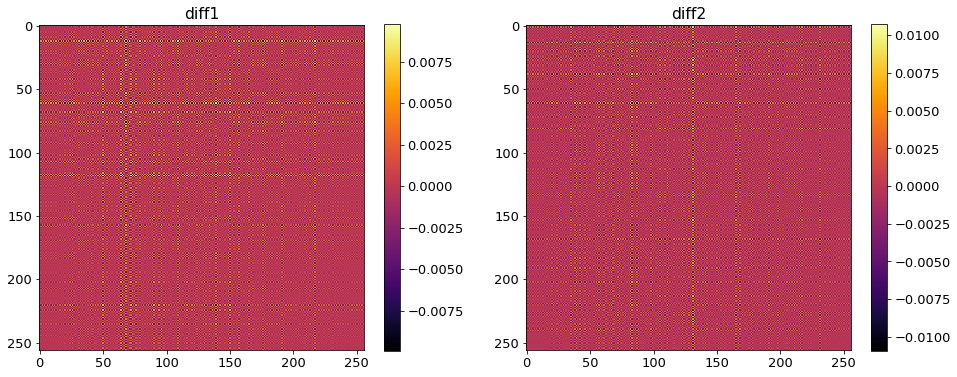

In [40]:
# define the kappa to shear operator
def H_operator(ka_map, kb_map):
    
    # ka_map and kb_map should be of the same size
    [nx,ny] = ka_map.shape
    
    ka_map_fft = np.fft.fft2(ka_map)
    kb_map_fft = np.fft.fft2(kb_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1 # avoid division with zero
    kafc =  (p1 * ka_map_fft - p2 * kb_map_fft) / f2
    kbfc =  (p1 * kb_map_fft + p2 * ka_map_fft) / f2
    
    g1_map = np.fft.ifft2(kafc).real
    g2_map = np.fft.ifft2(kbfc).real
    
    return g1_map, g2_map


# define the shear to convergence operator
def H_adjoint(g1_map, g2_map):
    
    [nx,ny] = g1_map.shape
    
    g1_map_ifft = np.fft.ifft2(g1_map)
    g2_map_ifft = np.fft.ifft2(g2_map)
    
    f1, f2 = np.meshgrid(np.fft.fftfreq(ny),np.fft.fftfreq(nx))
    
    p1 = f1 * f1 - f2 * f2
    p2 = 2 * f1 * f2
    f2 = f1 * f1 + f2 * f2
    f2[0,0] = 1
    g1fc =  (p1 * g1_map_ifft + p2 * g2_map_ifft) / f2
    g2fc =  (p1 * g2_map_ifft - p2 * g1_map_ifft) / f2
    
    kappa1 = np.fft.fft2(g1fc).real
    kappa2 = np.fft.fft2(g2fc).real
    
    return kappa1, kappa2



kwpe, kwpb = H_adjoint(g1_map, g2_map)

g1r, g2r = H_operator(kwpe, kwpb)

diff1 = g1r - g1_map
diff2 = g2r - g2_map

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kwpe, interpolation='none', cmap='inferno') 
ax1.set_title('kwp'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(ktrue, interpolation='none', cmap='inferno') 
ax2.set_title('ktrue'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(g1r, interpolation='none', cmap='inferno') 
ax1.set_title('g1r'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(g2r, interpolation='none', cmap='inferno') 
ax2.set_title('g2r'), plt.colorbar(cax2, ax=ax2)

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kg1 , interpolation='none', cmap='inferno') 
# ax1.set_title('kg1'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kg2, interpolation='none', cmap='inferno') 
# ax2.set_title('kg2'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(diff1, interpolation='none', cmap='inferno') 
ax1.set_title('diff1'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(diff2, interpolation='none', cmap='inferno') 
ax2.set_title('diff2'), plt.colorbar(cax2, ax=ax2)

plt.show()


In [41]:
# Compute once the Fourier kernels for the transform
k1, k2 = np.meshgrid(np.fft.fftfreq(npix), np.fft.fftfreq(npix))
denom = k1*k1 + k2*k2
denom[0, 0] = 1  # avoid division by 0
kernel1 = (k1**2 - k2**2)/denom
kernel2 = (2*k1*k2)/denom
# kernel2[0,0] = 0
# kernel1[0,0] = 0

def kappa_to_gamma(kappa):
    k = np.fft.fft2(kappa)
    g1 = np.fft.ifft2(kernel1 * k) 
    g2 = np.fft.ifft2(kernel2 * k)
    return g1.real - g2.imag, g2.real + g1.imag 

def gamma_to_kappa(gam1,gam2):
    g = gam1 + 1j*gam2
    return np.fft.ifft2((kernel1 - 1j*kernel2)* np.fft.fft2(g))


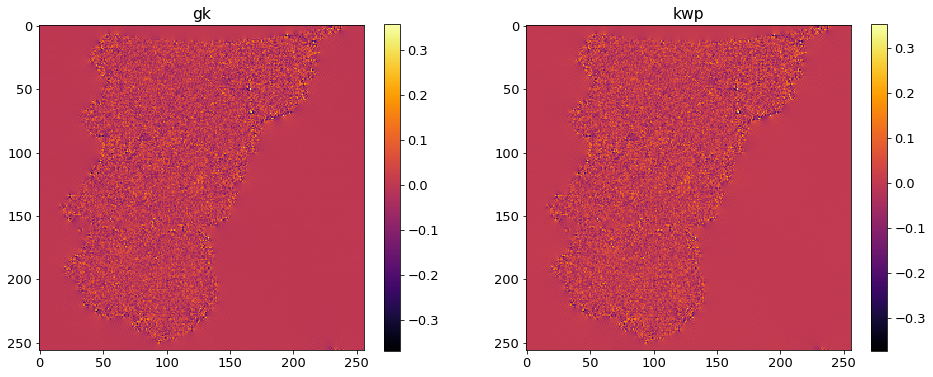

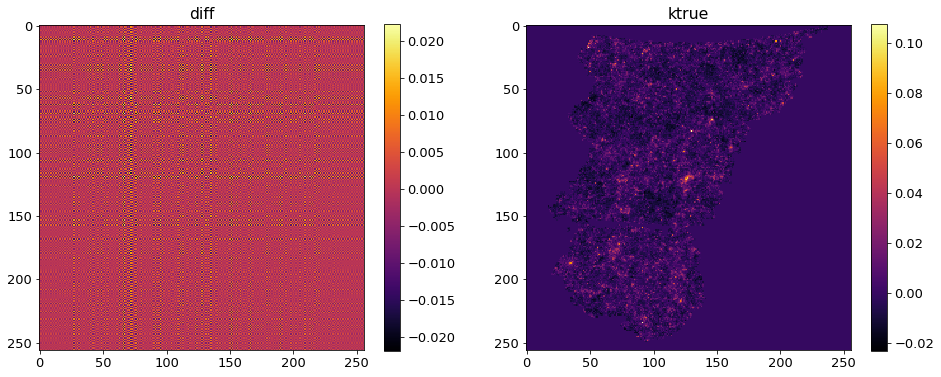

In [43]:
# check gamma_to_kappa transform c++

kwp = gamma_to_kappa(-e1, -e2)

gk = fits.getdata('../build/gamma_to_kappa.fits') 

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(gk , interpolation='none', cmap='inferno') 
ax1.set_title('gk'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(kwp.real, interpolation='none', cmap='inferno') 
ax2.set_title('kwp'), plt.colorbar(cax2, ax=ax2)

diff5 = gk - kwp.real

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(diff5, interpolation='none', cmap='inferno') 
ax1.set_title('diff'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(ktrue, interpolation='none', cmap='inferno') 
ax2.set_title('ktrue'), plt.colorbar(cax2, ax=ax2)

plt.show()


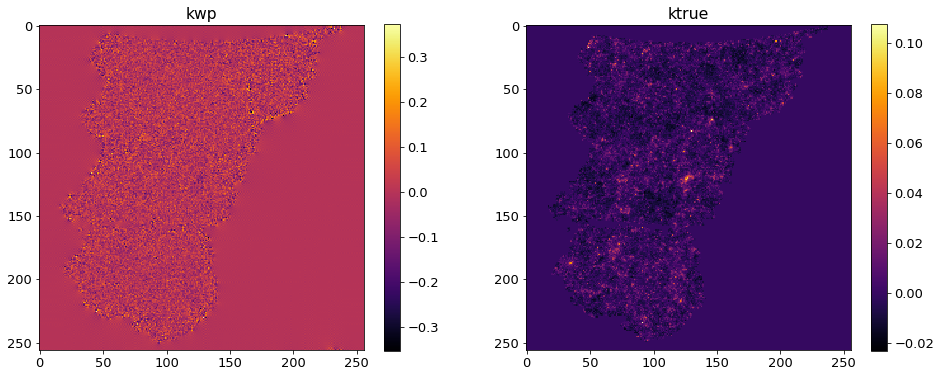

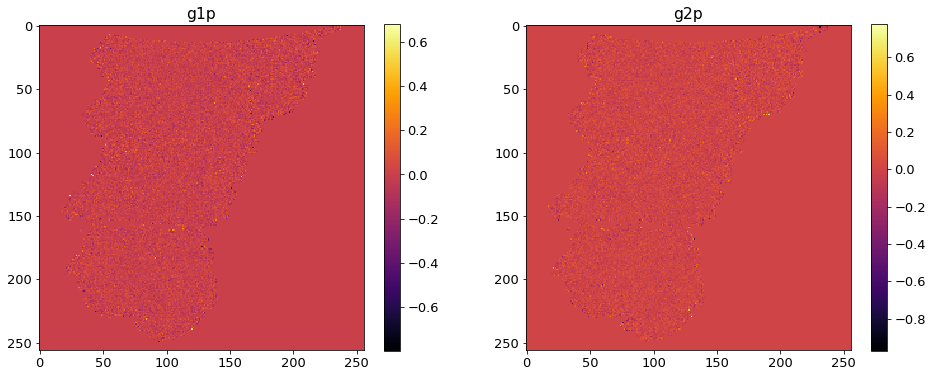

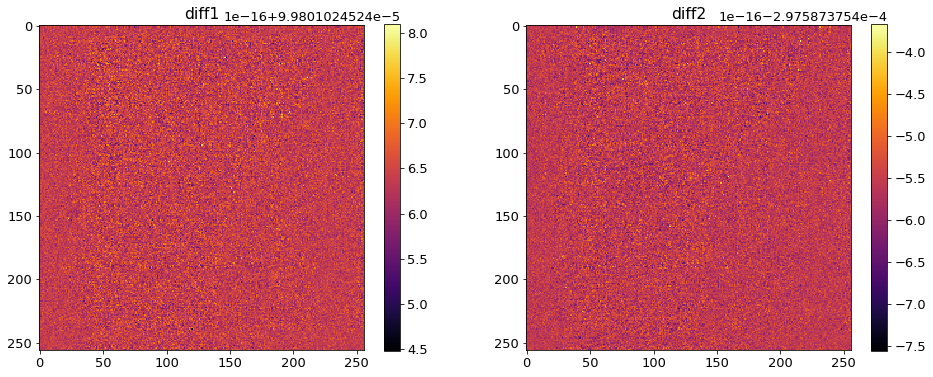

In [18]:
# check kappa to gamma transform from c++

g1p, g2p = kappa_to_gamma(kwp)

diff1 = g1p - e1
diff2 = g2p - e2

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(kwp.real, interpolation='none', cmap='inferno') 
ax1.set_title('kwp'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(ktrue, interpolation='none', cmap='inferno') 
ax2.set_title('ktrue'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(g1p, interpolation='none', cmap='inferno') 
ax1.set_title('g1p'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(g2p, interpolation='none', cmap='inferno') 
ax2.set_title('g2p'), plt.colorbar(cax2, ax=ax2)

# fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
# cax1 = ax1.imshow(kg1 , interpolation='none', cmap='inferno') 
# ax1.set_title('kg1'), plt.colorbar(cax1, ax=ax1)
# cax2 = ax2.imshow(kg2, interpolation='none', cmap='inferno') 
# ax2.set_title('kg2'), plt.colorbar(cax2, ax=ax2)

fig1, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
cax1 = ax1.imshow(diff1, interpolation='none', cmap='inferno') 
ax1.set_title('diff1'), plt.colorbar(cax1, ax=ax1)
cax2 = ax2.imshow(diff2, interpolation='none', cmap='inferno') 
ax2.set_title('diff2'), plt.colorbar(cax2, ax=ax2)

plt.show()